In [1]:
import numpy as np
from scipy import optimize
import os
import pandas as pd
import ipdb
import warnings
import torch
import torch.nn as nn
from s_annealing_cost_solution import compute_proper_ratio_pl
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")




# Defining the Cost Functions used

In [ ]:
def compute_distance_matrix(X, center_roads):
    lat2 = torch.deg2rad(X[:,0]).reshape((-1,1))
    lat1 = torch.deg2rad(center_roads[:,0]).reshape((1,-1))
    lon2 = torch.deg2rad(X[:,1]).reshape((-1,1))
    lon1 = torch.deg2rad(center_roads[:,1]).reshape((1,-1))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = torch.sin(dlat/2)**2 + torch.cos(lat1)*torch.cos(lat2)*torch.sin(dlon/2)**2
    c = 2*torch.arcsin(torch.sqrt(a))
    r = 6371
    distance_matrix_km = c*r
    return distance_matrix_km

def compute_output_costs(distance_matrix_km, flows, maximal_distance):
    outputs_costs=(
        distance_matrix_km.min(axis=0).values * (distance_matrix_km.min(axis=0).values>maximal_distance) 
        # + 0.5*distance_matrix_km.mean(axis=0)/2
        # + 0.01*(flows*(distance_matrix_km.min(axis=0).values<maximal_distance)*distance_matrix_km.min(axis=0).values/100).mean()
        +0.05*(distance_matrix_km<maximal_distance)*distance_matrix_km*flows/1000
        
    )
    return outputs_costs.mean()

# Implementing solution

## Defining the hyperparameters

In [3]:
number_clusters = 200
maximal_distance = 50
# maximal_distance = maximal_distance
steps = 20

## Results with the proper initialization thanks to K-Means

In [4]:
raw_data = pd.read_csv(os.path.join("data","tmja-2019.csv"), sep=";")
for colonne in raw_data.columns:
    try:
        raw_data[colonne] = raw_data[colonne].apply(lambda element:element.replace(',',"."))
    except:
        # print(raw_data[colonne].dtype)
        pass
for colonne in raw_data.columns:
    try:
        raw_data[colonne] = raw_data[colonne].astype(float)
    except:
        pass

df = raw_data[["route",'xD',"yD","xF", "yF","TMJA","ratio_PL"]]
df.loc[:, ['xD',"yD","xF", "yF"]]/=1e5
values =["x","y"]
for value in values:
    df.loc[:,f'center_{value}'] = (df.loc[:, f"{value}D"]+df.loc[:,f"{value}F"])/2
df['proper_ratio_PL'] = df["ratio_PL"].apply(compute_proper_ratio_pl)
df.dropna(inplace=True)
df["daily_flow_trucks"] = (df["proper_ratio_PL"]/100) *df['TMJA']
df['scaled_flow_trucks'] = df['daily_flow_trucks']/1000
Y = np.random.randn(number_clusters,2)
Y[:,0]+=5
Y[:,0]+=1
Y[:,1]+=64

cluster = KMeans(n_clusters=number_clusters,init='k-means++')
cluster.fit(df[['center_x','center_y']])
Y = cluster.cluster_centers_

Y_0 = torch.tensor(Y, requires_grad=True)
x = Y_0
center_roads = torch.Tensor(df[['center_x','center_y']].values)
flows = torch.Tensor(df['daily_flow_trucks'].values)
optimizer = torch.optim.SGD([x], lr=0.1)
for i in range(steps):
    # 
    optimizer.zero_grad()
    
    distance_matrix = compute_distance_matrix(x, center_roads)
    # distance_matrix_between_points = compute_distance_matrix(x, x)
    total_loss = compute_output_costs(distance_matrix, flows, maximal_distance)
    total_loss.backward()
    optimizer.step()
    if i%20==0:
        print(total_loss.detach())
    # x = torch.clamp(x, min=2, max=73)

tensor(0.1072, dtype=torch.float64)
tensor(0.0905, dtype=torch.float64)
tensor(0.0905, dtype=torch.float64)
tensor(0.0905, dtype=torch.float64)
tensor(0.0913, dtype=torch.float64)


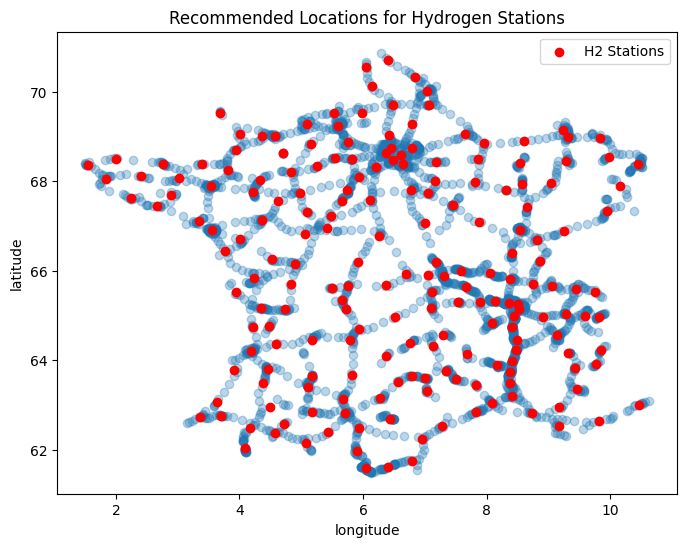

In [5]:
import matplotlib.pyplot as plt
x_plot = x.detach().cpu().numpy()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(df['center_x'], df['center_y'],alpha=0.3)
ax.scatter(x_plot[:,0], x_plot[:,1], color='red', label='H2 Stations')
plt.legend()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Recommended Locations for Hydrogen Stations')
plt.savefig('Recommended Locations for Hydrogen Stations')

## Results without the K-Means initialization

In [6]:
Y = np.random.randn(number_clusters,2)
Y[:,0]+=5
Y[:,0]+=1
Y[:,1]+=64

Y_0 = torch.tensor(Y, requires_grad=True)
x = Y_0
center_roads = torch.Tensor(df[['center_x','center_y']].values)
flows = torch.Tensor(df['daily_flow_trucks'].values)
optimizer = torch.optim.SGD([x], lr=0.1)
steps = 100
for i in range(steps):
    # 
    optimizer.zero_grad()
    
    distance_matrix = compute_distance_matrix(x, center_roads)
    # distance_matrix_between_points = compute_distance_matrix(x, x)
    total_loss = compute_output_costs(distance_matrix, flows, maximal_distance)
    total_loss.backward()
    optimizer.step()
    if i%20==0:
        print(total_loss.detach())

tensor(136.0608, dtype=torch.float64)
tensor(29.5357, dtype=torch.float64)
tensor(27.5826, dtype=torch.float64)
tensor(25.8434, dtype=torch.float64)
tensor(26.3190, dtype=torch.float64)


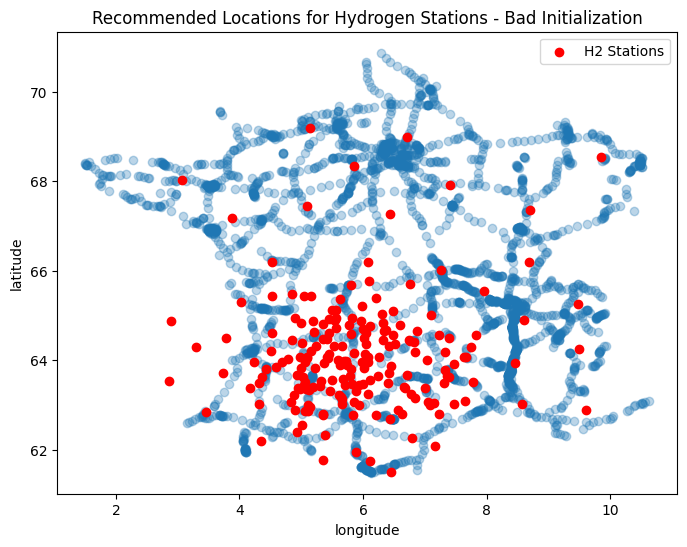

In [7]:
import matplotlib.pyplot as plt
x_plot = x.detach().cpu().numpy()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(df['center_x'], df['center_y'],alpha=0.3)
ax.scatter(x_plot[:,0], x_plot[:,1], color='red', label='H2 Stations')
plt.legend()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Recommended Locations for Hydrogen Stations - Bad Initialization')
plt.savefig('Recommended Locations for Hydrogen Stations - Bad Initialization')